In [1]:
import re
import glob

# Patterns to extract macro/JK/micro steps and CASSCF energies
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')


# Gather all log files
log_files = sorted(glob.glob("cas_init_result/log_*.txt"), key=lambda x: int(re.search(r'\d+', x).group()))
results = []

for log_file in log_files:
    with open(log_file, "r") as f:
        lines = f.readlines()

    # Extract steps
    matches_steps = [pattern_steps.search(line) for line in lines if "CASSCF converged" in line]
    matches_steps = [m for m in matches_steps if m]  # filter None
    
    # Extract energies
    matches_energy = [pattern_energy.search(line) for line in lines if "CASSCF energy" in line]
    matches_energy = [m for m in matches_energy if m]

    if len(matches_steps) >= 2 and len(matches_energy) >= 2:
        nn_steps = tuple(map(int, matches_steps[0].groups()))
        hf_steps = tuple(map(int, matches_steps[1].groups()))
        nn_energy = float(matches_energy[0].group(1))
        hf_energy = float(matches_energy[1].group(1))
        results.append((log_file, nn_steps, hf_steps, nn_energy, hf_energy))
    else:
        print(f"Warning: {log_file} missing matches (Steps: {len(matches_steps)}, Energies: {len(matches_energy)})")

# Print results in a formatted table
print(f"{'File':<15} {'NN_macro':>9} {'NN_JK':>6} {'NN_micro':>9} {'NN_energy':>14} | {'HF_macro':>9} {'HF_JK':>6} {'HF_micro':>9} {'HF_energy':>14}")
print("-" * 95)
for filename, nn_steps, hf_steps, nn_energy, hf_energy in results:
    print(f"{filename:<15} {nn_steps[0]:>9} {nn_steps[1]:>6} {nn_steps[2]:>9} {nn_energy:>14.8f} | "
          f"{hf_steps[0]:>9} {hf_steps[1]:>6} {hf_steps[2]:>9} {hf_energy:>14.8f}")


File             NN_macro  NN_JK  NN_micro      NN_energy |  HF_macro  HF_JK  HF_micro      HF_energy
-----------------------------------------------------------------------------------------------
cas_init_result/log_0.txt         3     44         9     0.03142583 |         8    105        23     0.03142583
cas_init_result/log_1.txt         3     28         7    -1.18673511 |         5     75        17    -1.18673510
cas_init_result/log_2.txt         3     25         7    -1.74917503 |         7     82        19    -1.74917502
cas_init_result/log_3.txt         3     23         7    -2.02128915 |         7     85        19    -2.02128915
cas_init_result/log_4.txt         2     15         5    -2.15180424 |         6     86        19    -2.15180424
cas_init_result/log_5.txt         2     15         5    -2.20866335 |         5     79        17    -2.20866335
cas_init_result/log_6.txt         2     14         5    -2.22552206 |         6     72        15    -2.22552206
cas_init_result/lo

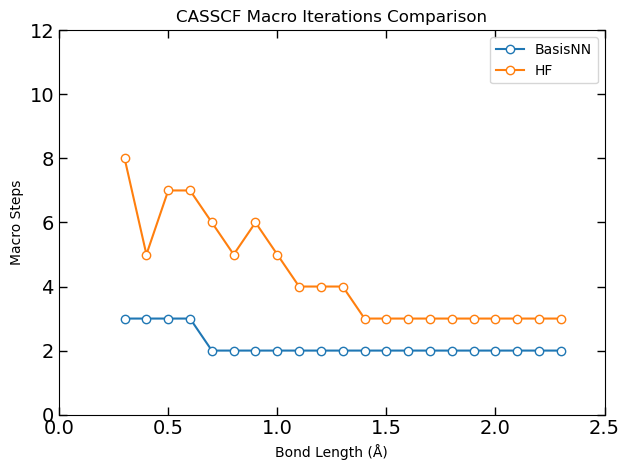

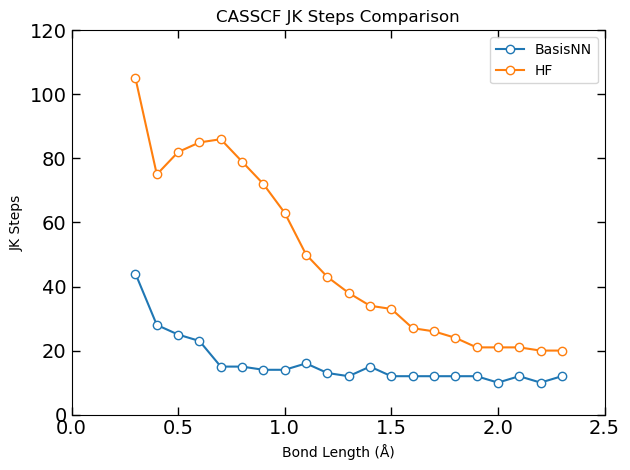

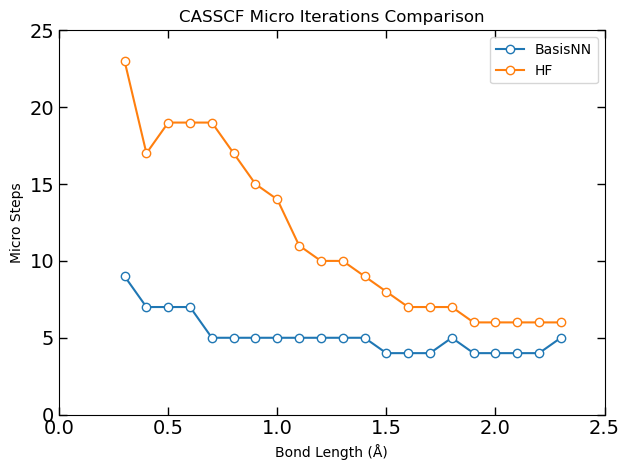

In [2]:
import numpy as np
import re
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = [bond_length_interval * point for point in range(3, num_chains + 1)]

# Regex patterns
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')

# Get and sort log files
log_files = sorted(glob.glob("cas_init_result/log_*.txt"), key=lambda x: int(re.search(r'\d+', x).group()))

# Prepare lists
nn_macro, nn_jk, nn_micro = [], [], []
hf_macro, hf_jk, hf_micro = [], [], []
nn_energy, hf_energy = [], []
indices = []

# Extract data from each log
for log_file in log_files:
    with open(log_file, "r") as f:
        lines = f.readlines()

    # Extract steps
    matches_steps = [pattern_steps.search(line) for line in lines if "CASSCF converged" in line]
    matches_steps = [m for m in matches_steps if m]

    # Extract energies
    matches_energy = [pattern_energy.search(line) for line in lines if "CASSCF energy" in line]
    matches_energy = [m for m in matches_energy if m]

    if len(matches_steps) >= 2 and len(matches_energy) >= 2:
        # Steps
        nn_data = tuple(map(int, matches_steps[0].groups()))
        hf_data = tuple(map(int, matches_steps[1].groups()))
        nn_macro.append(nn_data[0])
        nn_jk.append(nn_data[1])
        nn_micro.append(nn_data[2])
        hf_macro.append(hf_data[0])
        hf_jk.append(hf_data[1])
        hf_micro.append(hf_data[2])

        # Energies
        nn_energy.append(float(matches_energy[0].group(1)))
        hf_energy.append(float(matches_energy[1].group(1)))

        indices.append(int(re.search(r'\d+', log_file).group()))

# Plot step comparisons
fig_titles = ['Macro Iterations', 'JK Steps', 'Micro Iterations']
nn_data_all = [nn_macro, nn_jk, nn_micro]
hf_data_all = [hf_macro, hf_jk, hf_micro]
ylabels = ['Macro Steps', 'JK Steps', 'Micro Steps']
y2_l = [12, 120, 25]

for i in range(3):
    plt.figure()
    plt.plot(lengths[:-2], nn_data_all[i][:-2], label='BasisNN', marker='o', markerfacecolor='white')
    plt.plot(lengths[:-2], hf_data_all[i][:-2], label='HF', marker='o', markerfacecolor='white')
    plt.xlabel('Bond Length (Å)')
    plt.ylabel(ylabels[i])
    plt.title(f'CASSCF {fig_titles[i]} Comparison')
    plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
    plt.xlim(0, 2.5)
    plt.ylim(0, y2_l[i])
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'figs/casscf_{fig_titles[i].lower().replace(" ", "_")}.pdf', metadata={"TextAsShapes": False})


/var/folders/2g/30fq15_16yvcsfwpd5x9z9p80000gn/T/ipykernel_9169/4158726947.py:37: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'Keywords', 'Trapped', 'Subject', 'Creator', 'Title', 'CreationDate', 'ModDate', 'Author', 'Producer'}.
  plt.savefig("figs/log4_casscf_energy_curve.pdf",  metadata={"TextAsShapes": False})


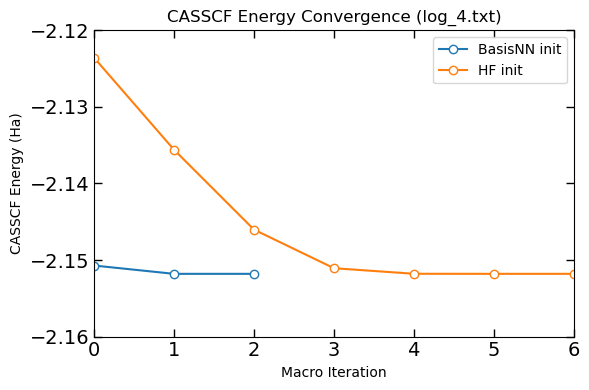

In [3]:
# Load log_4.txt
log_file = "cas_init_result/log_4.txt"
try:
    with open(log_file, "r") as f:
        lines = f.readlines()
except FileNotFoundError:
    raise FileNotFoundError(f"{log_file} not found in the current directory.")

# Extract initial CASCI energy
casci_lines = [line for line in lines if "CASCI E" in line]
basisNN_E0 = float(re.search(r"CASCI E =\s*(-?\d+\.\d+)", casci_lines[0]).group(1))
hf_E0 = float(re.search(r"CASCI E =\s*(-?\d+\.\d+)", casci_lines[2]).group(1))

# Extract macro iteration energies
macro_pattern = re.compile(r"CASSCF E =\s*(-?\d+\.\d+)")
macro_lines = [line for line in lines if "macro iter" in line]
basisNN_lines = macro_lines[:2]
hf_lines = macro_lines[2:]

basisNN_E = [basisNN_E0] + [float(macro_pattern.search(line).group(1)) for line in basisNN_lines]
hf_E = [hf_E0] + [float(macro_pattern.search(line).group(1)) for line in hf_lines]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(range(len(basisNN_E)), basisNN_E, label="BasisNN init",marker='o',markerfacecolor='white')
plt.plot(range(len(hf_E)), hf_E,  label="HF init",marker='o',markerfacecolor='white')
plt.xlabel("Macro Iteration")
plt.ylabel("CASSCF Energy (Ha)")
plt.title("CASSCF Energy Convergence (log_4.txt)")
plt.legend()
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
    
plt.xlim(0, 6)
plt.ylim(-2.16, -2.12)
#plt.grid(True)
plt.tight_layout()
plt.savefig("figs/log4_casscf_energy_curve.pdf",  metadata={"TextAsShapes": False})
plt.show()
